# Abstractive Text Summarization

## Libraries

In [1]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [15]:
!pip install -q contractions==0.0.48

In [16]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


## Getting the data

In [6]:
df=pd.read_excel("news.xlsx")

In [7]:
df

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25
...,...,...,...,...,...
55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the...",The Financial Express,10:36:00,2016-01-20
55100,China to inject $91 bn into the money markets,Amid growing concerns about China&#39;s econom...,Reuters,12:06:00,2016-01-20
55101,Ghulam Ali set to make acting debut in Bollywood,Pakistani Ghazal singer Ghulam Ali will soon m...,Hindustan Times,12:10:00,2016-01-20
55102,IS acknowledges death of Jihadi John: Report,The Islamic State (IS) has acknowledged the de...,YouTube,11:53:00,2016-01-20


In [13]:
df_columns = df.columns.tolist()
df_columns.remove('Headline')
df_columns.remove('Short')
df.drop(df_columns, axis='columns', inplace=True)

df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 55104


,Headline,Short
51253,TN passes bill for indirect election of mayors,Tamil Nadu on Thursday passed a bill seeking t...
40142,"Driver, worker save 50 from school bus on fire",A bus driver and construction worker from Mysu...
40095,Samsung launches its 1st 6 GB RAM phone in Ind...,"Samsung on Tuesday launched the Galaxy C9 Pro,..."
16858,Bahadur Rana wins gold at Walking Championships,The second and final day of the 3rd edition of...
18954,The Union Budget was leaked in 1950,"In 1950, a certain portion of the Union Budget..."


The `headlines` column will be treated as `summary` for the text.

##  Data cleaning

In [17]:
def expand_contractions(text, contraction_map=contractions_dict):
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [18]:
# Converting to lowercase
df.Short = df.Short.apply(str.lower)
df.Headline = df.Headline.apply(str.lower)

df.sample(5)

,Headline,Short
21557,18 union ministers yet to adopt a village: data,as many as 18 cabinet ministers are yet to ado...
49841,ex-un head annan to lead myanmar&#39;s rohingy...,myanmar has picked former un secretary general...
32791,"assembly elections 2017 begin as punjab, goa g...",the 2017 assembly elections have started as vo...
45476,&#39;dirty&#39; ship turned away from new zeal...,a &#34;dirty&#34; ship was ordered to leave th...
50713,calls to remove a trump aide from fb board cra...,facebook ceo mark zuckerberg defended the pres...


In [19]:
df.Headline = df.Headline.apply(expand_contractions)
df.Short = df.Short.apply(expand_contractions)
df.sample(5)

,Headline,Short
54278,"ban cow slter, beef sale: himachal hc to centre",the himachal pradesh high court on friday aske...
36888,40 tribals to be special guests at republic da...,forty tribal guests from different parts of th...
52080,&#39;game of thrones&#39; season 7 teaser rele...,the seventh season of tv show &#39;game of thr...
54,fruit-flavoured cup for drinking water developed,a us startup has developed a fruit-flavoured c...
51412,where was blood coming from: mla asks rape vic...,"rashtriya lok samta party&#39;s mla in bihar, ..."


In [20]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [alphabet for alphabet in word if alphabet not in string.punctuation]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [21]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [22]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [23]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [24]:
df.Short = df.Short.apply(clean_text)
df.Headline = df.Headline.apply(clean_text)
df.sample(5)

,Headline,Short
358,millionth rolls audis ingolstadt plant,german automaker audi thursday rolled milliont...
47369,india truly literate littering stops naidu,union minister venkaiah naidu friday said indi...
44464,shekhar kapoor head jury film fest macau,actor filmmaker shekhar kapur known directing ...
51087,pictures yearold joins school nepal,sixtyeightyearold nepalese man durga kami join...
26630,video explores radioactive ghost towns japan,twominute video shows group explorers visited ...


In [25]:
df.to_csv('cleaned_data.csv')

In [26]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

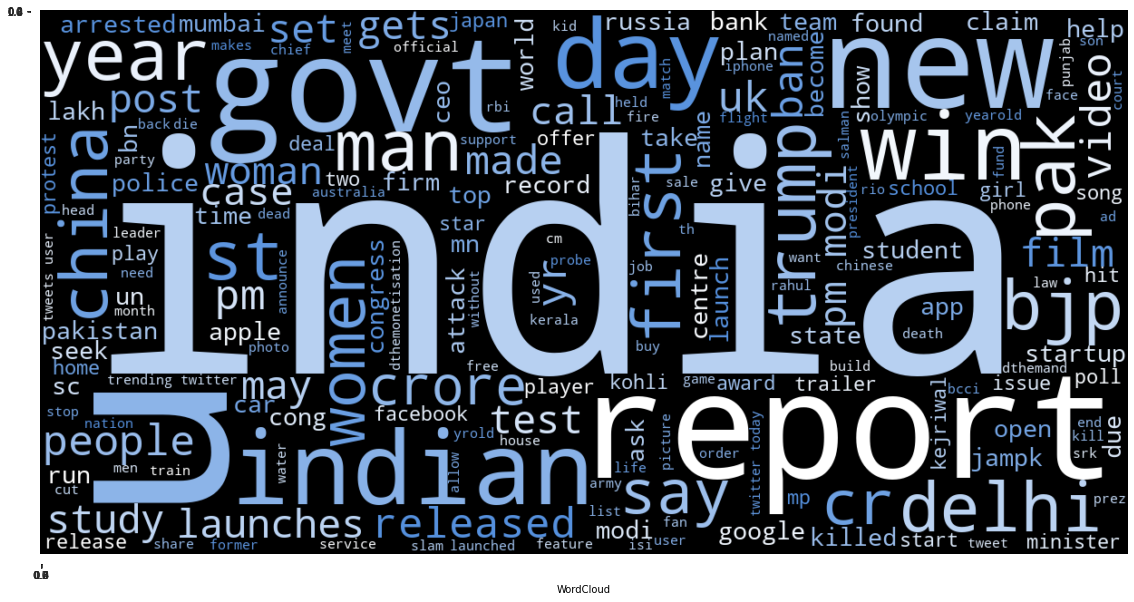

In [28]:
plot_wordcloud(' '.join(df.Headline.values.tolist()), wc_blue_color_func)

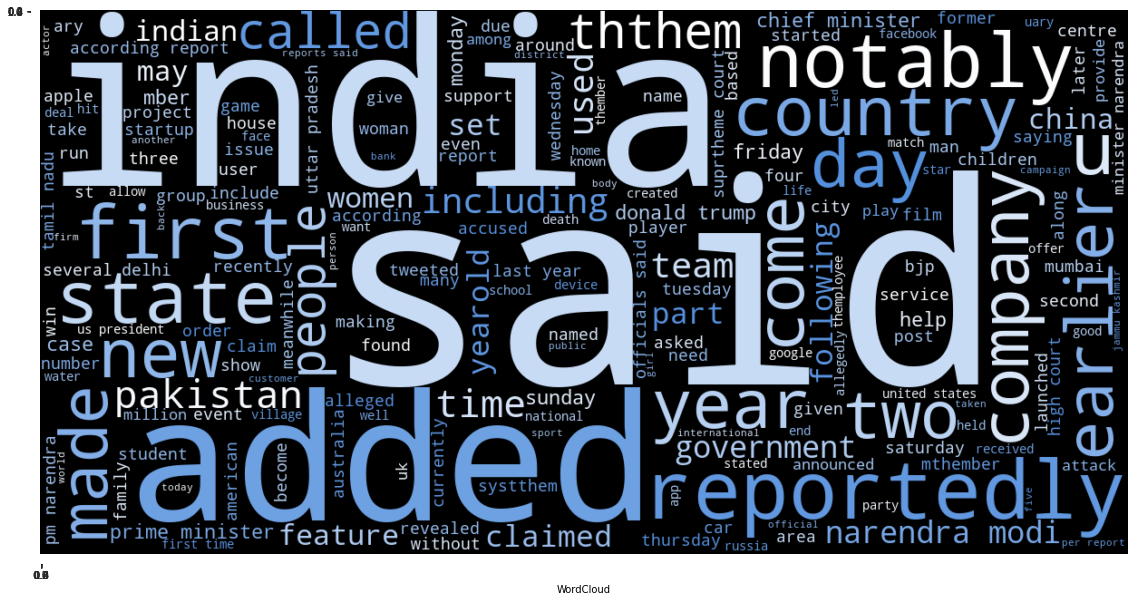

In [29]:
plot_wordcloud(' '.join(df.Short.values.tolist()), wc_blue_color_func)

## Data preparation

In [ ]:
df=pd.read_csv("cleaned_data.csv")

Using a `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

In [31]:
df.Headline = df.Headline.apply(lambda x: f'_START_ {x} _END_')

Again adding `tokens` ... but different ones.

In [32]:
start_token = 'sostok'
end_token = 'eostok'
df.Headline = df.Headline.apply(lambda x: f'{start_token} {x} {end_token}')

In [33]:
df.sample(5)

,Headline,Short
35127,sostok _START_ sena slams mundes selfies droug...,shiv sena monday slammed maharashtras rural de...
24066,sostok _START_ abandoned witchchild makes reco...,abandoned twoyearold nigerian child rescued ai...
40885,sostok _START_ lovetwitter trending twitter to...,twitters th birthday lovetwitter top global tw...
8865,sostok _START_ yuvraj tweets yeah baby selecti...,retweeting tweet comeback indian cricket team ...
36183,sostok _START_ wont go home till afspa repeale...,human rights activist irom sharmila said wont ...


Finding what should be the `maximum length` of text and headlines that will be feed or accepted by the learning algorithm.

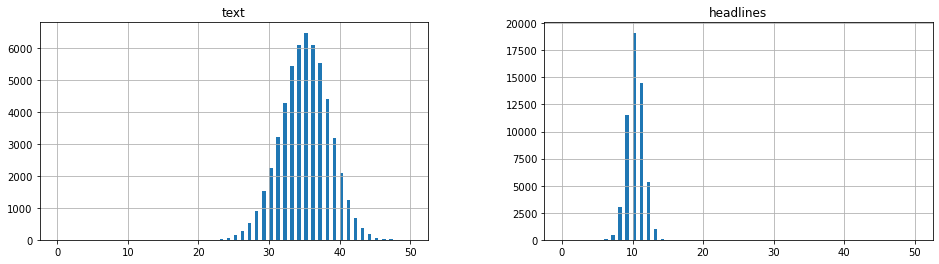

In [34]:
text_count = [len(sentence.split()) for sentence in df.Short]
headlines_count = [len(sentence.split()) for sentence in df.Headline]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [35]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.Headline, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.Short, 42))

1.0
0.99


In [36]:
max_text_len = 42
max_summary_len = 13

In [37]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['Short'])
    cleaned_summary = np.array(df['Headline'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(cleaned_summary[i].split()) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 54309


,text,summary
4236,shanghai time court china sold seized foreign ...,sostok _START_ chinese court sells seized ship...
35087,swedishborn businessman johan eliasch bought l...,sostok _START_ man bought forests size delhi p...
24104,mannerless majnu new song taapsee pannu amit s...,sostok _START_ mannerless majnu song runningsh...
24098,according reports kanpur district uttar prades...,sostok _START_ kanpur records hiv cases months...
50429,hong kong legislative council blocked three pr...,sostok _START_ hong kong lawmakers blocked ins...


In [38]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [46]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

**Tokenizing text x**

In [47]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.15, 'total_coverage': 4.18, 'count': 49623, 'total_count': 76168}


In [49]:
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

x_vocab_size = len(x_tokenizer.word_index) + 1
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

76169


**Tokenizing headlines(summary) y**

In [51]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 73.82, 'total_coverage': 7.73, 'count': 21483, 'total_count': 29103}


In [53]:
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

y_vocab_size = len(y_tokenizer.word_index) + 1
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

29104


In [55]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

## Modelling

In [56]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

In [60]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = 'glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file,"r",encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 49094 words (27074 misses)
Found 400000 word vectors.
Converted 22617 words (6486 misses)


In [61]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(76169, 300)
(29104, 300)


Using `pre-trained` embeddings and keeping the `Embedding` layer `non-trainable` we get increase in computation speed as don't need to compute the embedding matrix.

**Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.

In [62]:
def build_seq2seq_model_with_just_lstm(embedding_dim, latent_dim, max_text_len,
                                       x_vocab_size, y_vocab_size,
                                       x_embedding_matrix, y_embedding_matrix):
    encoder_input = Input(shape=(max_text_len, ))
    
    encoder_embedding = Embedding(x_vocab_size,
                                  embedding_dim,
                                  embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
                                  trainable=False)(encoder_input)
    encoder_lstm1 = LSTM(latent_dim,
                         return_sequences=True,
                         return_state=True,
                         dropout=0.4,
                         recurrent_dropout=0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)
        
    encoder_lstm2 = LSTM(latent_dim,
                         return_sequences=True,
                         return_state=True,
                         dropout=0.4,
                         recurrent_dropout=0.4)
    encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

    decoder_input = Input(shape=(None, ))

    decoder_embedding_layer = Embedding(y_vocab_size,
                                        embedding_dim,
                                        embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
                                        trainable=True)
    decoder_embedding = decoder_embedding_layer(decoder_input)


    decoder_lstm = LSTM(latent_dim,
                        return_sequences=True,
                        return_state=True,
                        dropout=0.4,
                        recurrent_dropout=0.4)
    decoder_output, *decoder_final_states = decoder_lstm(decoder_embedding, initial_state=encoder_final_states)

    decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
        decoder_output = decoder_dense(decoder_output)

    model = Model([encoder_input, decoder_input], decoder_output)
    model.summary()

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return {'model': model,
            'inputs': {'encoder': encoder_input,
                       'decoder': decoder_input},
            'outputs': {'encoder': encoder_output,
                        'decoder': decoder_output},
            'states': {'encoder': encoder_final_states,
                       'decoder': decoder_final_states},
            'layers': {'decoder': {'embedding': decoder_embedding_layer,
                                   'last_decoder_lstm': decoder_lstm,
                                   'dense': decoder_dense}}
            }

**Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.

In [63]:
def build_seq2seq_model_with_bidirectional_lstm(embedding_dim, latent_dim, max_text_len, 
                                                x_vocab_size, y_vocab_size,
                                                x_embedding_matrix, y_embedding_matrix):
    encoder_input = Input(shape=(max_text_len, ))

    encoder_embedding = Embedding(x_vocab_size,
                                  embedding_dim,
                                  embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
                                  trainable=False,
                                  name='encoder_embedding')(encoder_input)
    
    encoder_bi_lstm1 = Bidirectional(LSTM(latent_dim,
                                          return_sequences=True,
                                          return_state=True,
                                          dropout=0.4,
                                          recurrent_dropout=0.4,
                                          name='encoder_lstm_1'),
                                     name='encoder_bidirectional_lstm_1')
    encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(encoder_embedding)
    encoder_bi_lstm1_output = [encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1]

    encoder_bi_lstm2 = Bidirectional(LSTM(latent_dim,
                                          return_sequences=True,
                                          return_state=True,
                                          dropout=0.4,
                                          recurrent_dropout=0.4,
                                          name='encoder_lstm_2'),
                                     name='encoder_bidirectional_lstm_2')
    encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(encoder_output1)
    encoder_bi_lstm2_output = [encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2]
    
    encoder_bi_lstm = Bidirectional(LSTM(latent_dim,
                                         return_sequences=True,
                                         return_state=True,
                                         dropout=0.4,
                                         recurrent_dropout=0.4,
                                         name='encoder_lstm_3'),
                                    name='encoder_bidirectional_lstm_3')
    encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)
    
    decoder_input = Input(shape=(None, ))
    
    decoder_embedding_layer = Embedding(y_vocab_size,
                                        embedding_dim,
                                        embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
                                        trainable=False,
                                        name='decoder_embedding')
    decoder_embedding = decoder_embedding_layer(decoder_input)
    
    decoder_bi_lstm = Bidirectional(LSTM(latent_dim,
                                         return_sequences=True,
                                         return_state=True,
                                         dropout=0.4,
                                         recurrent_dropout=0.2,
                                         name='decoder_lstm_1'),
                                    name='decoder_bidirectional_lstm_1')
    decoder_output, *decoder_final_states = decoder_bi_lstm(decoder_embedding, initial_state=encoder_final_states)
    
    decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
    decoder_output = decoder_dense(decoder_output)

    model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
    model.summary()
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return {'model': model,
            'inputs': {'encoder': encoder_input,
                       'decoder': decoder_input},
            'outputs': {'encoder': encoder_output,
                        'decoder': decoder_output},
            'states': {'encoder': encoder_final_states,
                       'decoder': decoder_final_states},
            'layers': {'decoder': {'embedding': decoder_embedding_layer,
                                   'last_decoder_lstm': decoder_bi_lstm,
                                   'dense': decoder_dense}}
            }

**Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

In [64]:
def build_hybrid_seq2seq_model(embedding_dim, latent_dim, max_text_len, 
                               x_vocab_size, y_vocab_size,
                               x_embedding_matrix, y_embedding_matrix):
    encoder_input = Input(shape=(max_text_len, ))

    encoder_embedding = Embedding(x_vocab_size,
                                  embedding_dim,
                                  embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
                                  trainable=False,
                                  name='encoder_embedding')(encoder_input)
    encoder_bi_lstm1 = Bidirectional(LSTM(latent_dim,
                                          return_sequences=True,
                                          return_state=True,
                                          dropout=0.4,
                                          recurrent_dropout=0.4,
                                          name='encoder_lstm_1'),
                                     name='encoder_bidirectional_lstm_1')
    encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(encoder_embedding)
    encoder_bi_lstm1_output = [encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1]
    
    encoder_bi_lstm2 = Bidirectional(LSTM(latent_dim,
                                          return_sequences=True,
                                          return_state=True,
                                          dropout=0.4,
                                          recurrent_dropout=0.4,
                                          name='encoder_lstm_2'),
                                     name='encoder_bidirectional_lstm_2')
    encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(encoder_output1)
    encoder_bi_lstm2_output = [encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2]

    encoder_bi_lstm = Bidirectional(LSTM(latent_dim,
                                         return_sequences=True,
                                         return_state=True,
                                         dropout=0.4,
                                         recurrent_dropout=0.4,
                                         name='encoder_lstm_3'),
                                    name='encoder_bidirectional_lstm_3')
    encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

    decoder_input = Input(shape=(None, ))

    decoder_embedding_layer = Embedding(y_vocab_size,
                                        embedding_dim,
                                        embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
                                        trainable=False,
                                        name='decoder_embedding')
    decoder_embedding = decoder_embedding_layer(decoder_input)
    
    decoder_lstm = LSTM(latent_dim,
                        return_sequences=True,
                        return_state=True,
                        dropout=0.4,
                        recurrent_dropout=0.2,
                        name='decoder_lstm_1')
    decoder_output, *decoder_final_states = decoder_lstm(decoder_embedding, initial_state=encoder_final_states[:2])
    
    decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
    decoder_output = decoder_dense(decoder_output)

    model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
    model.summary()

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return {'model': model,
            'inputs': {'encoder': encoder_input,
                       'decoder': decoder_input},
            'outputs': {'encoder': encoder_output,
                        'decoder': decoder_output},
            'states': {'encoder': encoder_final_states,
                       'decoder': decoder_final_states},
            'layers': {'decoder': {'embedding': decoder_embedding_layer,
                                   'last_decoder_lstm': decoder_lstm,
                                   'dense': decoder_dense}}
            }

In [65]:
seq2seq = build_seq2seq_model_with_just_lstm(embedding_dim, latent_dim, max_text_len, 
                                             x_vocab_size, y_vocab_size,
                                             x_embedding_matrix, y_embedding_matrix)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 300)      22850700    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 240), (N 519360      embedding[0][0]                  
______________________________________________________________________________________________

If you want to change `model` then just change the `function name` above.

In [66]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [67]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

## Training

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
             ModelCheckpoint(filepath="model_lstm_attention.h5", verbose=1, save_best_only=True)]

In [70]:
history = model.fit([x_train_padded, y_train_padded[:, :-1]],
                    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
                    epochs=num_epochs,
                    batch_size=128,
                    callbacks=callbacks,
                    validation_data=([x_val_padded, y_val_padded[:, :-1]],
                                     y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]))

Epoch 1/50
382/382 [==============================] - 247s 619ms/step - loss: 4.8352 - accuracy: 0.4612 - val_loss: 4.2958 - val_accuracy: 0.5105
Epoch 2/50
382/382 [==============================] - 232s 608ms/step - loss: 4.3304 - accuracy: 0.4962 - val_loss: 3.9452 - val_accuracy: 0.5202
Epoch 3/50
382/382 [==============================] - 230s 602ms/step - loss: 4.0461 - accuracy: 0.5071 - val_loss: 3.7306 - val_accuracy: 0.5300
Epoch 4/50
382/382 [==============================] - 233s 609ms/step - loss: 3.8522 - accuracy: 0.5164 - val_loss: 3.6058 - val_accuracy: 0.5367
Epoch 5/50
382/382 [==============================] - 225s 590ms/step - loss: 3.7071 - accuracy: 0.5248 - val_loss: 3.5109 - val_accuracy: 0.5436
Epoch 6/50
382/382 [==============================] - 225s 588ms/step - loss: 3.5935 - accuracy: 0.5327 - val_loss: 3.4431 - val_accuracy: 0.5474
Epoch 7/50
382/382 [==============================] - 224s 586ms/step - loss: 3.4968 - accuracy: 0.5395 - val_loss: 3.3814 -

**Plotting model's performance**

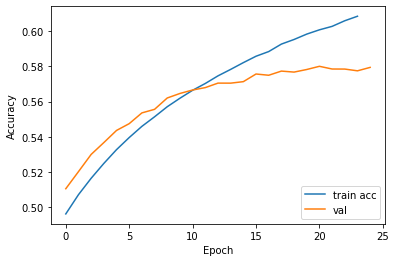

In [71]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

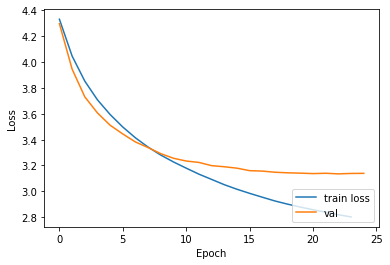

In [72]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Inference

In [73]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [74]:
def build_seq2seq_model_with_just_lstm_inference(max_text_len, latent_dim, encoder_input, encoder_output,
                                                 encoder_final_states, decoder_input, decoder_output,
                                                 decoder_embedding_layer, decoder_dense, last_decoder_lstm):
    
    # Encode the input sequence to get the feature vector
    encoder_model = Model(inputs=encoder_input, outputs=[encoder_output] + encoder_final_states)

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(decoder_embedding,
                                                        initial_state=[decoder_state_input_h, decoder_state_input_c])

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model([decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
                          [decoder_output] + decoder_states)

    return (encoder_model, decoder_model)

Useful `stackoverflow` [post](https://stackoverflow.com/questions/60697843/tensorflow-keras-bidirectional-lstm-for-text-summarization) to understand `inference` process when using `bidirectional lstms` in `encoder` and `decoder` in the training model.

In [75]:
def build_seq2seq_model_with_bidirectional_lstm_inference(max_text_len, latent_dim, encoder_input, encoder_output,
                                                          encoder_final_states, decoder_input, decoder_output,
                                                          decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm):
    
    # Encode the input sequence to get the feature vector
    encoder_model = Model(inputs=encoder_input, outputs=[encoder_output] + encoder_final_states)
    
    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get 
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [decoder_state_forward_input_h, decoder_state_forward_input_c,
                             decoder_state_backward_input_h, decoder_state_backward_input_c]
    
    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(decoder_embedding, initial_state=decoder_initial_state)

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model([decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
                          [decoder_output] + decoder_states)

    return (encoder_model, decoder_model)

In [76]:
def build_hybrid_seq2seq_model_inference(max_text_len, latent_dim, encoder_input, encoder_output,
                                         encoder_final_states, decoder_input, decoder_output,
                                         decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(inputs=encoder_input, outputs=[encoder_output] + encoder_final_states)

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get 
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [decoder_state_forward_input_h, decoder_state_forward_input_c,
        #decoder_state_backward_input_h, decoder_state_backward_input_c
                             ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(decoder_embedding, initial_state=decoder_initial_state)

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model([decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
                          [decoder_output] + decoder_states)
    
    return (encoder_model, decoder_model)

In [77]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(max_text_len, latent_dim, encoder_input, encoder_output,
                                                                            encoder_final_states, decoder_input, decoder_output,
                                                                            decoder_embedding_layer, decoder_dense, last_decoder_lstm)

In [78]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 42, 300)           22850700  
_________________________________________________________________
lstm (LSTM)                  [(None, 42, 240), (None,  519360    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 42, 240), (None,  461760    
Total params: 23,831,820
Trainable params: 981,120
Non-trainable params: 22,850,700
_________________________________________________________________


In [79]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    8731200     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 240)]        0                                            
____________________________________________________________________________________________

In [80]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

![](https://media.giphy.com/media/XKSa6XxpmHh1NEBvvl/giphy.gif)

Converting from `sequence to text` for model `with just LSTM's` and for model `with Bidirectional LSTM's`.

In [81]:
def decode_sequence_seq2seq_model_with_just_lstm(input_sequence, encoder_model, decoder_model):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [82]:
def decode_sequence_seq2seq_model_with_bidirectional_lstm(input_sequence, encoder_model, decoder_model):
    
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict([target_seq] + [e_out] + state_values)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]
        
        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [83]:
def decode_sequence_hybrid_seq2seq_model(input_sequence, encoder_model, decoder_model):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict([target_seq] + [e_out] + state_values[:2])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]
        
        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [84]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if ((i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [85]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [86]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


For predicting `unseen` data pass `decode_sequence` function for which you want to decode.

In [87]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(padded.reshape(1, max_text_len), encoder_model, decoder_model)
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(_text.split())  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(_padded.reshape(1, max_text_len), encoder_model, decoder_model)
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

##  Predictions

In [88]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print("Predicted summary: ",decode_sequence_seq2seq_model_with_just_lstm(x_train_padded[i].reshape(1, max_text_len),
                                                                             encoder_model,
                                                                             decoder_model))
    print()

# 1 News:  twelve militants killed drone strikes southern ythemen suspected carried united states residents said thursday one persons killed could reportedly new head islamic state ythemen one strike took place al rawda city province abyan 
Original summary:  start drone strikes kill militants ythemen end 
Predicted summary:   start taliban attack kills us drone strikes end

# 2 News:  following protests staged jats seeking reservation obc category haryana government today announced introduce special bill upcoming assthembly session giving quota community allparty meeting held cm manohar lal khattar today discuss ways end agitation one person killed 
Original summary:  start haryana govt promises quota jat community end 
Predicted summary:   start haryana quota quota mlas protest end

# 3 News:  adoption drive retired military dogs held select citywalk mall delhi saturday four fullytrained retired military dogs well abandoned stray dogs twoday drive meanwhile first indotibetan border p

In [89]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print("Predicted summary: ", decode_sequence_seq2seq_model_with_just_lstm(x_val_padded[i].reshape(1, max_text_len),
                                                                              encoder_model,
                                                                              decoder_model))
    print()

# 1 News:  transgender persons protection rights bill seeks provide rate identity transgenders prohibits discrimination ththem introduced lok sabha tuesday bill also proposes stringent punishment crimes committed transgenders india notably six lakh people belonging transgender community reside india 
Original summary:  start bill aiming thempower transgenders tabled ls end 
Predicted summary:   start bill rights rights rights rights rights rights rights rights end

# 2 News:  ing paki go back ing india ing hindu camel riding mother abuses hurled white man indianorigin canadian man canada racial rthemarks reportedly made disagrethement parking truck in case people think racism doesnt happen canada wrote twitter 
Original summary:  start man faces go back fing india slur end 
Predicted summary:   start man takes back wedding party india end

# 3 News:  germanybased researchers reengineered mechanism used plants transform carbon dioxide co useful products produce efficient process known c

## Saving the model

In [90]:
# HDF5 format
model.save('model.h5')    
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

## 🏌️‍♂️ Running all the 3 different models

After understanding how all the pieces work, running all the `3 models` to understand how it `performs` and its `results`.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`

![](https://media.giphy.com/media/3ogmaPGsQOruw/giphy.gif)

In [70]:
models_info = {
    'just_lstm': {
        'model': build_seq2seq_model_with_just_lstm,
        'inference': build_seq2seq_model_with_just_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_just_lstm
    },
    'bidirectional_lstm': {
        'model': build_seq2seq_model_with_bidirectional_lstm,
        'inference': build_seq2seq_model_with_bidirectional_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_bidirectional_lstm
    },
    'hybrid_model': {
        'model': build_hybrid_seq2seq_model,
        'inference': build_hybrid_seq2seq_model_inference,
        'decode_sequence': decode_sequence_hybrid_seq2seq_model
    }
}

**Model with just LSTMs**

In [71]:
model_func = models_info['just_lstm']['model']
inference_func = models_info['just_lstm']['inference']
decode_sequence_func = models_info['just_lstm']['decode_sequence']

In [72]:
seq2seq = model_func(embedding_dim, latent_dim, max_text_len, 
                     x_vocab_size, y_vocab_size,
                     x_embedding_matrix, y_embedding_matrix)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 300)      29932800    input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 42, 240), (N 519360      embedding_2[0][0]                
____________________________________________________________________________________________

In [73]:
history = model.fit([x_train_padded, y_train_padded[:, :-1]],
                    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
                    epochs=num_epochs,
                    batch_size=128,
                    callbacks=callbacks,
                    validation_data=([x_val_padded, y_val_padded[:, :-1]],
                                     y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]))

Epoch 1/50
89/89 [==============================] - 37s 227ms/step - loss: 7.0021 - accuracy: 0.2465 - val_loss: 5.1189 - val_accuracy: 0.4284
Epoch 2/50
89/89 [==============================] - 5s 51ms/step - loss: 5.2113 - accuracy: 0.4181 - val_loss: 4.9496 - val_accuracy: 0.4316
Epoch 3/50
89/89 [==============================] - 5s 51ms/step - loss: 5.0362 - accuracy: 0.4231 - val_loss: 4.7615 - val_accuracy: 0.4370
Epoch 4/50
89/89 [==============================] - 5s 51ms/step - loss: 4.8063 - accuracy: 0.4281 - val_loss: 4.5179 - val_accuracy: 0.4447
Epoch 5/50
89/89 [==============================] - 5s 51ms/step - loss: 4.5459 - accuracy: 0.4360 - val_loss: 4.3064 - val_accuracy: 0.4520
Epoch 6/50
89/89 [==============================] - 5s 52ms/step - loss: 4.3302 - accuracy: 0.4434 - val_loss: 4.1767 - val_accuracy: 0.4577
Epoch 7/50
89/89 [==============================] - 5s 52ms/step - loss: 4.1516 - accuracy: 0.4506 - val_loss: 4.0780 - val_accuracy: 0.4600
Epoch 8/50


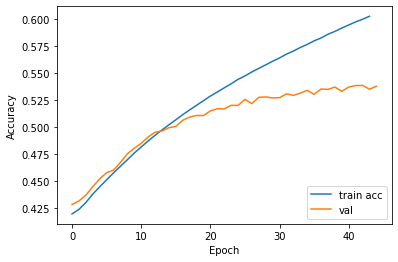

In [74]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

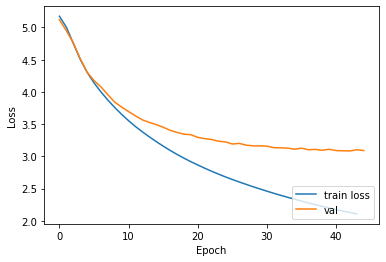

In [75]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [76]:
# Inference
encoder_model, decoder_model = inference_func(max_text_len, latent_dim, encoder_input, encoder_output,
                                              encoder_final_states, decoder_input, decoder_output,
                                              decoder_embedding_layer, decoder_dense, last_decoder_lstm)

In [77]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 42, 300)           29932800  
_________________________________________________________________
lstm_3 (LSTM)                [(None, 42, 240), (None,  519360    
_________________________________________________________________
lstm_4 (LSTM)                [(None, 42, 240), (None,  461760    
Total params: 30,913,920
Trainable params: 981,120
Non-trainable params: 29,932,800
_________________________________________________________________


In [78]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 300)    11257200    input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 240)]        0                                            
____________________________________________________________________________________________

In [79]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print("Predicted summary: ",decode_sequence_func(x_train_padded[i].reshape(1, max_text_len),
                                                     encoder_model,
                                                     decoder_model))
    print()

# 1 News:  spanish fashion retailer zara withdrawn skirt website facing criticism featuring pepe frog internet mtheme turned symbol white nationalist altright movthement zara seriously wallet shopping elsewhere commented user hmm pepe zara skirt wtf read another comment 
Original summary:  start zara withdraws skirt featuring pepe frog altright mtheme end 
Predicted summary:   start zara launches ad featuring pepe frog altright dress end

# 2 News:  elections fill vacant seats rajya sabha held today mthembers elected unopposed one seats facing byelections kerala mp resigned mber mthembers uttar pradesh maharashtra bihar six mthembers gujarat four 
Original summary:  start explained details rajya sabha election held today end 
Predicted summary:   start rajya sabha seats rajya sabha seats end

# 3 News:  first posthumous nobel prize awarded swedens erik karlfeldt literature posthumous nobel peace prize given youngest united nations secretarygeneral dag hamkjaald economist william vickre

**Model with Bidirectional LSTMs**

In [80]:
model_func = models_info['bidirectional_lstm']['model']
inference_func = models_info['bidirectional_lstm']['inference']
decode_sequence_func = models_info['bidirectional_lstm']['decode_sequence']

In [81]:
seq2seq = model_func(embedding_dim, latent_dim, max_text_len, 
                     x_vocab_size, y_vocab_size,
                     x_embedding_matrix, y_embedding_matrix)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 42, 300)      29932800    input_11[0][0]                   
__________________________________________________________________________________________________
encoder_bidirectional_lstm_1 (B [(None, 42, 480), (N 1038720     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________

In [82]:
history = model.fit([x_train_padded, y_train_padded[:, :-1]],
                    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
                    epochs=num_epochs,
                    batch_size=128 * tpu_strategy.num_replicas_in_sync,
                    callbacks=callbacks,
                    validation_data=([x_val_padded, y_val_padded[:, :-1]],
                                     y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]))

Epoch 1/50
89/89 [==============================] - 61s 334ms/step - loss: 6.4102 - accuracy: 0.3250 - val_loss: 4.3666 - val_accuracy: 0.4567
Epoch 2/50
89/89 [==============================] - 7s 83ms/step - loss: 4.2414 - accuracy: 0.4610 - val_loss: 3.2875 - val_accuracy: 0.5459
Epoch 3/50
89/89 [==============================] - 7s 82ms/step - loss: 3.2620 - accuracy: 0.5488 - val_loss: 2.4934 - val_accuracy: 0.6362
Epoch 4/50
89/89 [==============================] - 7s 82ms/step - loss: 2.5241 - accuracy: 0.6396 - val_loss: 1.9252 - val_accuracy: 0.7176
Epoch 5/50
89/89 [==============================] - 7s 83ms/step - loss: 1.9854 - accuracy: 0.7159 - val_loss: 1.5201 - val_accuracy: 0.7789
Epoch 6/50
89/89 [==============================] - 7s 84ms/step - loss: 1.5887 - accuracy: 0.7749 - val_loss: 1.2316 - val_accuracy: 0.8263
Epoch 7/50
89/89 [==============================] - 7s 83ms/step - loss: 1.2919 - accuracy: 0.8190 - val_loss: 1.0260 - val_accuracy: 0.8556
Epoch 8/50


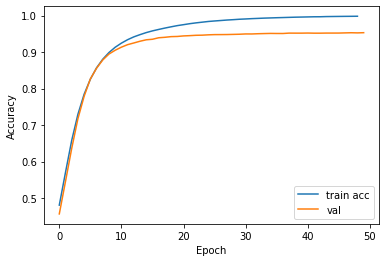

In [83]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

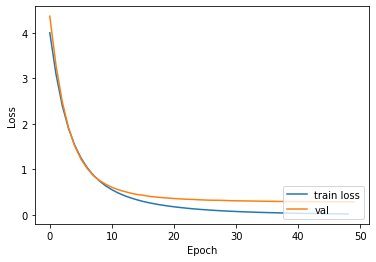

In [84]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [85]:
# Inference
encoder_model, decoder_model = inference_func(max_text_len, latent_dim, encoder_input, encoder_output,
                                              encoder_final_states, decoder_input, decoder_output,
                                              decoder_embedding_layer, decoder_dense, last_decoder_lstm)

In [86]:
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
encoder_embedding (Embedding (None, 42, 300)           29932800  
_________________________________________________________________
encoder_bidirectional_lstm_1 [(None, 42, 480), (None,  1038720   
_________________________________________________________________
encoder_bidirectional_lstm_2 [(None, 42, 480), (None,  1384320   
_________________________________________________________________
encoder_bidirectional_lstm_3 [(None, 42, 480), (None,  1384320   
Total params: 33,740,160
Trainable params: 3,807,360
Non-trainable params: 29,932,800
_________________________________________________________________


In [87]:
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 300)    11257200    input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 240)]        0                                            
____________________________________________________________________________________________

In [88]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print("Predicted summary: ",decode_sequence_func(x_train_padded[i].reshape(1, max_text_len),
                                                     encoder_model,
                                                     decoder_model))
    print()

# 1 News:  spanish fashion retailer zara withdrawn skirt website facing criticism featuring pepe frog internet mtheme turned symbol white nationalist altright movthement zara seriously wallet shopping elsewhere commented user hmm pepe zara skirt wtf read another comment 
Original summary:  start zara withdraws skirt featuring pepe frog altright mtheme end 
Predicted summary:   end end end end end end end end end end end end

# 2 News:  elections fill vacant seats rajya sabha held today mthembers elected unopposed one seats facing byelections kerala mp resigned mber mthembers uttar pradesh maharashtra bihar six mthembers gujarat four 
Original summary:  start explained details rajya sabha election held today end 
Predicted summary:   end end end end end end end end end end end end

# 3 News:  first posthumous nobel prize awarded swedens erik karlfeldt literature posthumous nobel peace prize given youngest united nations secretarygeneral dag hamkjaald economist william vickrey died prese

### Model with hybrid architecture

In [89]:
model_func = models_info['hybrid_model']['model']
inference_func = models_info['hybrid_model']['inference']
decode_sequence_func = models_info['hybrid_model']['decode_sequence']

In [90]:
seq2seq = model_func(embedding_dim, latent_dim, max_text_len, 
                     x_vocab_size, y_vocab_size,
                     x_embedding_matrix, y_embedding_matrix)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 42, 300)      29932800    input_18[0][0]                   
__________________________________________________________________________________________________
encoder_bidirectional_lstm_1 (B [(None, 42, 480), (N 1038720     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________

In [91]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 49s 270ms/step - loss: 7.0281 - accuracy: 0.2449 - val_loss: 5.1333 - val_accuracy: 0.4277
Epoch 2/50
89/89 [==============================] - 6s 71ms/step - loss: 5.2092 - accuracy: 0.4184 - val_loss: 4.9388 - val_accuracy: 0.4325
Epoch 3/50
89/89 [==============================] - 6s 71ms/step - loss: 5.0413 - accuracy: 0.4215 - val_loss: 4.7435 - val_accuracy: 0.4359
Epoch 4/50
89/89 [==============================] - 6s 72ms/step - loss: 4.7893 - accuracy: 0.4276 - val_loss: 4.5190 - val_accuracy: 0.4422
Epoch 5/50
89/89 [==============================] - 6s 72ms/step - loss: 4.5488 - accuracy: 0.4336 - val_loss: 4.3426 - val_accuracy: 0.4483
Epoch 6/50
89/89 [==============================] - 6s 72ms/step - loss: 4.3701 - accuracy: 0.4389 - val_loss: 4.2001 - val_accuracy: 0.4542
Epoch 7/50
89/89 [==============================] - 6s 72ms/step - loss: 4.2124 - accuracy: 0.4449 - val_loss: 4.0844 - val_accuracy: 0.4589
Epoch 8/50


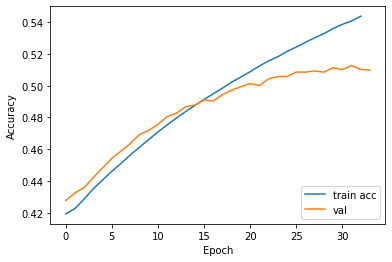

In [92]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

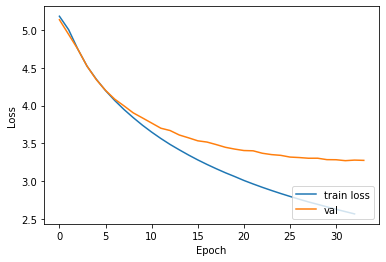

In [93]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [94]:
# Inference
encoder_model, decoder_model = inference_func(max_text_len, latent_dim, encoder_input, encoder_output,
                                              encoder_final_states, decoder_input, decoder_output,
                                              decoder_embedding_layer, decoder_dense, last_decoder_lstm)

In [95]:
encoder_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
encoder_embedding (Embedding (None, 42, 300)           29932800  
_________________________________________________________________
encoder_bidirectional_lstm_1 [(None, 42, 480), (None,  1038720   
_________________________________________________________________
encoder_bidirectional_lstm_2 [(None, 42, 480), (None,  1384320   
_________________________________________________________________
encoder_bidirectional_lstm_3 [(None, 42, 480), (None,  1384320   
Total params: 33,740,160
Trainable params: 3,807,360
Non-trainable params: 29,932,800
_________________________________________________________________


In [96]:
decoder_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 300)    11257200    input_19[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 240)]        0                                            
____________________________________________________________________________________________

In [97]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ", decode_sequence_func(x_train_padded[i].reshape(1, max_text_len),
                                                    encoder_model,
                                                    decoder_model))
    print()

# 1 News:  spanish fashion retailer zara withdrawn skirt website facing criticism featuring pepe frog internet mtheme turned symbol white nationalist altright movthement zara seriously wallet shopping elsewhere commented user hmm pepe zara skirt wtf read another comment 
Original summary:  start zara withdraws skirt featuring pepe frog altright mtheme end 
Predicted summary:   sostok abvp instagram dthemocracy filed filed filed volcano start india end end

# 2 News:  elections fill vacant seats rajya sabha held today mthembers elected unopposed one seats facing byelections kerala mp resigned mber mthembers uttar pradesh maharashtra bihar six mthembers gujarat four 
Original summary:  start explained details rajya sabha election held today end 
Predicted summary:   sostok fm ied using lawyer lawyer lawyer birth start india end end

# 3 News:  first posthumous nobel prize awarded swedens erik karlfeldt literature posthumous nobel peace prize given youngest united nations secretarygeneral